In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init

In [2]:
def train_data(N_x, x_l, x_r, del_x, N_t, t_i, t_f, del_t, N_bc, N_ic):

    x_train = np.geomspace(x_l+0.001, x_r-0.001, N_x)
    x_train = np.tile(x_train, N_t)
    x_bc1 = np.zeros(N_bc)
    x_bc2 = np.ones(N_bc)*x_r
    x_ic = np.random.uniform(x_l, x_r, N_ic)
    x_train = np.concatenate((x_train,x_bc1,x_bc2,x_ic),0)
    x_train = torch.FloatTensor(x_train)
    x_train = x_train.unsqueeze(-1)
    x_train = x_train.clone().detach().requires_grad_(True)

    t_start = t_i + 0.001 
    t_end = t_start + del_t*(N_t-1) 
    t_array = np.geomspace(t_start, t_end, N_t)
    t_train = np.repeat(t_array, N_x)
    t_bc = np.random.uniform(t_i, t_f, 2*N_bc)
    t_ic = np.zeros(N_ic)
    t_train = np.concatenate((t_train, t_bc, t_ic),0)
    t_train = torch.FloatTensor(t_train)
    t_train = t_train.unsqueeze(-1)
    t_train = t_train.clone().detach().requires_grad_(True)
    
    return x_train, t_train

def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)
    
class FVMANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FVMANN, self).__init__()
        
        # Fully conected model
        modules = []
        for i in range(len(hidden_size)):
            if(i==0):
                modules.append(nn.Linear(input_size, hidden_size[i]))
            else:
                modules.append(nn.Linear(hidden_size[i-1], hidden_size[i]))  
            modules.append(nn.Tanh())
                
        modules.append(nn.Linear(hidden_size[-1], output_size))
        modules.append(nn.Tanh())
        self.fc = nn.Sequential(*modules)
        
        # initialise the weights
#         if isinstance(self.fc, nn.Linear):
#             constant_value = 0.1
#             init.constant_(m.weight, constant_value)
#             init.constant_(m.bias, constant_value)

#         for layer in self.fc.modules():
#             if isinstance(layer, nn.Linear):
#                 layer.weight.data.normal_(mean=0, std=0.2)
        
    def forward(self, x_train, t_train):
        op = self.fc(torch.cat((x_train, t_train),1))
        op_t = torch.autograd.grad(op, t_train, grad_outputs=torch.ones_like(op), create_graph=True)[0]
        op_x = torch.autograd.grad(op, x_train, grad_outputs=torch.ones_like(op), create_graph=True)[0]
        op_x2 = torch.autograd.grad(op_x, x_train, grad_outputs=torch.ones_like(op_x), create_graph=True)[0]
        return op, op_t, op_x2
    
def train_model(model, optimiser, epochs, T_r, T_l, k1, N_x, x_l, x_r, del_x, N_t, t_i, t_f, del_t, N_bc, N_ic, T_ini):
    
    loss_store = []
    mse = nn.MSELoss(reduction='sum')
    model.train()  
    
    w1 = 1
    w2 = 6
    w3 = 6
    w4 = 1
        
    N_tot = N_t*N_x + 2*N_bc + N_ic
    null = torch.zeros(N_tot)
    null = null.unsqueeze(-1)

    for epoch in range(epochs):

        x_train, t_train = train_data(N_x, x_l, x_r, del_x, N_t, t_i, t_f, del_t, N_bc, N_ic)
        T, dTdt, d2Tdx2 = model(x_train, t_train)

        eq1 = w1*mse(dTdt, k1*d2Tdx2)/(N_tot)
        ic1 = w2*mse( torch.mul(torch.where(t_train == t_i,1,0),(T - T_ini )), null )/N_ic
        bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - T_l)), null )/N_bc
        bc2 = w4*mse( torch.mul(torch.where(x_train == x_r,1,0),(T - T_r)), null )/N_bc

        optimiser.zero_grad()
        loss = eq1 + bc1 + bc2 + ic1
        loss.backward()
        optimiser.step()

        loss_store.append(loss.detach().numpy())

        if epoch%200==0:   
            print('epoch = ',epoch)
            print('loss = ',loss.detach().numpy())
            print('eq1_loss = ',eq1.detach().numpy())
            print('ic1_loss = ',ic1.detach().numpy())
            print('bc1_loss = ',bc1.detach().numpy())
            print('bc2_loss = ',bc2.detach().numpy())

    return loss_store



In [20]:
N_x = 35
N_t = 35
N_bc = 100
N_ic = 100
x_l = 0
x_r = 0.7
t_i = 0
t_f = 0.8
del_t = (t_f - (t_i + 0.001))/(N_t - 1)
del_x = (x_r - x_l - 0.002)/(N_x - 1)
T_l = 1.0
T_r = 0.0
T_ini = 0

# Neural network params
input_size = 2
hidden_size = [45, 45, 45, 45, 45, 45]
output_size = 1

# material params
k1 = 0.05

# Training data and initial data
model = FVMANN(input_size, hidden_size, output_size)
model.apply(xavier_init)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# Setup Loss function and Optimiser
learning_rate = 6e-6
optimiser = torch.optim.AdamW(model.parameters(), lr=learning_rate)
epochs = 40000

# Training model
loss_store = train_model(model, optimiser, epochs, T_r, T_l, k1, N_x, x_l, x_r, del_x, N_t, t_i, t_f, del_t, N_bc, N_ic, T_ini)

FVMANN(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=45, bias=True)
    (1): Tanh()
    (2): Linear(in_features=45, out_features=45, bias=True)
    (3): Tanh()
    (4): Linear(in_features=45, out_features=45, bias=True)
    (5): Tanh()
    (6): Linear(in_features=45, out_features=45, bias=True)
    (7): Tanh()
    (8): Linear(in_features=45, out_features=45, bias=True)
    (9): Tanh()
    (10): Linear(in_features=45, out_features=45, bias=True)
    (11): Tanh()
    (12): Linear(in_features=45, out_features=1, bias=True)
    (13): Tanh()
  )
)
Total trainable parameters in the model: 10531
epoch =  0
loss =  6.4666986
eq1_loss =  0.008139278
ic1_loss =  0.0033525408
bc1_loss =  6.4505796
bc2_loss =  0.004627164
epoch =  200
loss =  4.719334
eq1_loss =  0.02558443
ic1_loss =  0.015604427
bc1_loss =  4.6659007
bc2_loss =  0.012244899
epoch =  400
loss =  3.5205822
eq1_loss =  0.1402699
ic1_loss =  0.04516758
bc1_loss =  3.290415
bc2_loss =  0.04472947
epoch =  600
loss 

epoch =  12200
loss =  0.4759032
eq1_loss =  0.07805272
ic1_loss =  0.22751197
bc1_loss =  0.16958193
bc2_loss =  0.00075657427
epoch =  12400
loss =  0.39793903
eq1_loss =  0.07040938
ic1_loss =  0.14105172
bc1_loss =  0.18550417
bc2_loss =  0.00097372546
epoch =  12600
loss =  0.43783867
eq1_loss =  0.06460269
ic1_loss =  0.22688824
bc1_loss =  0.14529322
bc2_loss =  0.0010545288
epoch =  12800
loss =  0.3951307
eq1_loss =  0.06359026
ic1_loss =  0.15735996
bc1_loss =  0.17304902
bc2_loss =  0.0011314512
epoch =  13000
loss =  0.3877924
eq1_loss =  0.06362683
ic1_loss =  0.15442127
bc1_loss =  0.16893992
bc2_loss =  0.0008043964
epoch =  13200
loss =  0.35640156
eq1_loss =  0.063970946
ic1_loss =  0.13194962
bc1_loss =  0.15975308
bc2_loss =  0.0007279105
epoch =  13400
loss =  0.37917006
eq1_loss =  0.06469583
ic1_loss =  0.16178907
bc1_loss =  0.15165049
bc2_loss =  0.0010346655
epoch =  13600
loss =  0.4127892
eq1_loss =  0.06629857
ic1_loss =  0.1808711
bc1_loss =  0.16493471
bc2

epoch =  25000
loss =  0.25040537
eq1_loss =  0.027211862
ic1_loss =  0.13278432
bc1_loss =  0.09010574
bc2_loss =  0.0003034575
epoch =  25200
loss =  0.16475064
eq1_loss =  0.026941108
ic1_loss =  0.07494194
bc1_loss =  0.06253875
bc2_loss =  0.0003288318
epoch =  25400
loss =  0.19795671
eq1_loss =  0.026769139
ic1_loss =  0.090927504
bc1_loss =  0.07986197
bc2_loss =  0.00039809995
epoch =  25600
loss =  0.23058105
eq1_loss =  0.025392244
ic1_loss =  0.13610213
bc1_loss =  0.06870815
bc2_loss =  0.0003785261
epoch =  25800
loss =  0.26130047
eq1_loss =  0.02474439
ic1_loss =  0.16091025
bc1_loss =  0.075158894
bc2_loss =  0.0004869443
epoch =  26000
loss =  0.22483808
eq1_loss =  0.02516749
ic1_loss =  0.10187923
bc1_loss =  0.097395316
bc2_loss =  0.00039604056
epoch =  26200
loss =  0.24065745
eq1_loss =  0.024256054
ic1_loss =  0.121483766
bc1_loss =  0.094530776
bc2_loss =  0.00038684547
epoch =  26400
loss =  0.2032077
eq1_loss =  0.023611253
ic1_loss =  0.12259344
bc1_loss = 

epoch =  37600
loss =  0.10391457
eq1_loss =  0.012313427
ic1_loss =  0.03392063
bc1_loss =  0.057631582
bc2_loss =  4.8930076e-05
epoch =  37800
loss =  0.14541823
eq1_loss =  0.012151354
ic1_loss =  0.0734401
bc1_loss =  0.059750672
bc2_loss =  7.61052e-05
epoch =  38000
loss =  0.10580603
eq1_loss =  0.012116948
ic1_loss =  0.023403788
bc1_loss =  0.07023633
bc2_loss =  4.8966012e-05
epoch =  38200
loss =  0.10680693
eq1_loss =  0.012324966
ic1_loss =  0.0459786
bc1_loss =  0.048464336
bc2_loss =  3.9025887e-05
epoch =  38400
loss =  0.12776937
eq1_loss =  0.01196726
ic1_loss =  0.06654826
bc1_loss =  0.04917553
bc2_loss =  7.8320576e-05
epoch =  38600
loss =  0.07406546
eq1_loss =  0.011685378
ic1_loss =  0.02797236
bc1_loss =  0.034350682
bc2_loss =  5.704361e-05
epoch =  38800
loss =  0.07423111
eq1_loss =  0.011329705
ic1_loss =  0.022860577
bc1_loss =  0.040000726
bc2_loss =  4.0101964e-05
epoch =  39000
loss =  0.15080523
eq1_loss =  0.011788533
ic1_loss =  0.054533042
bc1_los

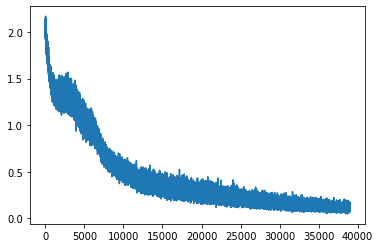

In [21]:
# x = np.linspace(1, len(loss_store), len(loss_store))
plt.plot(loss_store[1000:])

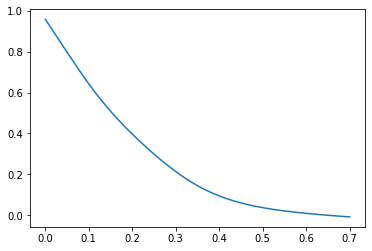

In [24]:
N_test = 2000

t_pred = 0.5
x_test = torch.linspace(x_r,x_l,N_test)
t_test = torch.ones(N_test)*t_pred
x_test = x_test.unsqueeze(-1)
t_test = t_test.unsqueeze(-1)
x_test = x_test.clone().detach().requires_grad_(True)
t_test = t_test.clone().detach().requires_grad_(True)

y_pred,_,_  = model(x_test, t_test )
y_pred = y_pred.detach().numpy()
x_test = x_test.detach().numpy()
plt.plot(x_test, y_pred)

In [19]:
y_pred

array([[-0.00704656],
       [-0.00702681],
       [-0.00700656],
       ...,
       [ 0.85293835],
       [ 0.8569879 ],
       [ 0.8610435 ]], dtype=float32)